In [1]:
# %matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import random
import xraydb

random.seed(0)

## Modulator design

In [2]:
def calculate_delta_beta_xraydb(material,energy):
    
    if material == 'Ni': # nickel
        density = 8.908 # g/cm^3
    elif material == 'Si': # silicon
        density = 2.329002
    elif material == 'W': # tungsten
        density = 19.25
        
    delta, beta, attenuation_length = xraydb.xray_delta_beta(material,density,energy)
    return delta, beta 

def calculate_delta_and_beta_from_f1_f2(f1, f2, rho_a):
    # rho_a : atomic number density in atoms/m^3
    electron_radius = 2.8179403262e-15
    factor = electron_radius*rho_a*wavelength**2/(2*np.pi) 
    delta, beta = factor*f1, factor*f2
    return delta, beta 

def calculate_delta_and_beta_nickel():

    rho_a = 6.0221e23*8.908*1e6/58.69 # atomic number density nickel, atoms/m^3 -> 6.0221e23mol-1 * 8.908 g/cm3 * 1e6/ 58.69g/mol
    f1 = 2.63786E+01
    f2 = 3.4017E+00
    electron_radius = 2.8179403262e-15

    factor = electron_radius*rho_a*wavelength**2/(2*np.pi) 
    beta = factor*f2
    delta = factor*f1
    
    return delta, beta

def calculate_delta_and_beta_silicon():
    # http://ts-imaging.science.unimelb.edu.au/Services/Simple/ICUtilXdata.aspx
    delta = 6.0502E-06 
    beta = 1.1338E-07
    return delta, beta

def calculate_delta_and_beta_tungsten():

    rho_a = 6.0221e23*19.25*1e6/183.84 # atomic number density tungsten, atoms/m^3
    f1=7.391e1 # tungsten value 39 keV
    f2=1.7219 # tungsten value 39 keV

    electron_radius = 2.8179403262e-15

    factor = electron_radius*rho_a*wavelength**2/(2*np.pi) 
    beta = factor*f2
    delta = factor*f1

    # delta = 2.0958531068493e-06 # http://purple.iptm.ru/xcalc/xcalc_mysql/ref_index.php tungsten 39keV
    # beta = 5.1036163210706e-08
    
    delta = 3.645703245482E-05 # tungsten 9keV
    beta = 2.5977314266174E-06 # tungsten 9keV
    
    return delta, beta

def create_modulator(ny,nx, pixel_size,radius,nb_of_points):

    modulator = np.zeros((nx,ny))

    NY = np.linspace(0,ny-1,ny) #- ny//2
    NX = np.linspace(0,nx-1,nx) #- nx//2
    NY, NX = np.meshgrid(NY,NX)
    NY, NX = pixel_size*NY, pixel_size*NX

    center_coordinates = []
    counter = 0
    while counter < nb_of_points:
        x_ctr_coordinates = nx*np.random.rand(1)*pixel_size
        y_ctr_coordinates = ny*np.random.rand(1)*pixel_size

        modulator2 = modulator + np.where( (NX-x_ctr_coordinates)**2 + (NY-y_ctr_coordinates)**2 <= radius**2, 1 , 0)
        if (modulator2>1).any(): # if >1, there is overlap of balls. then skip
            pass
        else: # else, add it to the modulator
            modulator = modulator2
            counter += 1
            center_coordinates.append((x_ctr_coordinates,y_ctr_coordinates))

    # fig, ax = plt.subplots()
    # ax.imshow(modulator)

    return modulator, center_coordinates



Material:  W
Wavelength = 0.13776 nm
delta = 3.609e-05 	 beta: 2.500e-06
Thickness for pi phase shift = 1.909 microns
Minimum transmission = 0.804
Maximum phase shift = 3.142


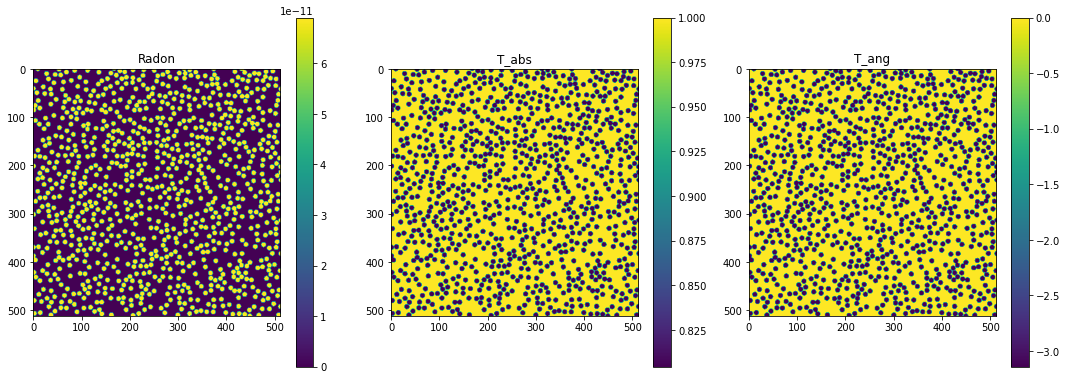

In [11]:
energy = 9e3 # eV
material = 'W'
# material = 'Si'
# material = 'Ni'
print('Material: ',material)
substrate = False

ny, nx = 512, 512
pixel_size = 60 # nm
nb_of_points = 1000 # number of holes in the modulator
radius = 300 # nm ; radius of holes in the modulator

def create_real_material_modulator(energy,material,ny,nx,pixel_size,nb_of_points,radius,substrate=False):

    c = 299792458    # Velocity of Light [m/s]
    plank = 4.135667662E-15  # Plank constant [ev*s]
    const = plank * c
    wavelength =  const / energy   # [m]  wavelenght 
    k = 2*np.pi/wavelength
    print(f'Wavelength = {wavelength*1e9:.5f} nm')

    modulator_mask,_ = create_modulator(ny,nx, pixel_size,radius,nb_of_points)

    delta_value, beta_value = calculate_delta_beta_xraydb(material, energy)
    print(f'delta = {delta_value:.3e} \t beta: {beta_value:.3e}')

    delta = delta_value*modulator_mask
    beta  = beta_value*modulator_mask

    pi_shift_thickness = np.pi/k/delta_value
    print(f"Thickness for pi phase shift = {pi_shift_thickness*1e6:.3f} microns")

    sample_thickness = pi_shift_thickness # 1.8e-6 #m
    radon = sample_thickness*(delta-1j*beta)
    transmission_function = np.exp(-1j*k*radon)
    
    if substrate: 
        substrate_delta, substrate_beta = calculate_delta_beta_xraydb('Si', energy)
        substrate_thickness = 1e-6 # um
        substrate_transmission_function = np.exp(-1j*k*substrate_thickness*(substrate_delta*np.ones_like(delta)-1j*substrate_beta*np.ones_like(beta)))
        transmission_function = transmission_function*substrate_transmission_function
        
    print(f"Minimum transmission = {np.min(np.abs(transmission_function)):.3f}")
    print(f"Maximum phase shift = {np.max(np.abs(np.angle(transmission_function))):.3f}")

    return transmission_function, radon


transmission, radon = create_real_material_modulator(energy,material,ny,nx,pixel_size,nb_of_points,radius,substrate)

# wavefront = abs( pj.propagation(transmission, z2, pixeldet, energy, magn, adjoint = False) ) # Forward projection
# intensity = np.abs(wavefront)**2

fig, ax = plt.subplots(1,3,figsize=(15,10))
ax0 = ax[0].imshow(np.abs(radon))
ax[0].set_title('Radon')
ax1 = ax[1].imshow(np.abs(transmission))
ax[1].set_title('T_abs')
ax2 = ax[2].imshow(np.angle(transmission))
ax[2].set_title('T_ang')
fig.colorbar(ax0, ax=ax[0],shrink=0.5)
fig.colorbar(ax1, ax=ax[1],shrink=0.5)
fig.colorbar(ax2, ax=ax[2],shrink=0.5)
fig.tight_layout()

if 0:
    np.save(f"modulators/modulator_{radius:.0f}_nm.npy",transmission)